Import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import node2vec

ModuleNotFoundError: No module named 'node2vec'

Get the data

In [2]:
meta = pd.read_csv('Levin 2016 Biol Lett data/LevinAttributeFile.csv')
contact = np.genfromtxt("Levin 2016 Biol Lett data/LevinContactNetwork.csv", delimiter=',')[1:,1:]
social = np.genfromtxt("Levin 2016 Biol Lett data/LevinSocialNetwork.csv", delimiter=',')[1:,1:]

Generate the graph

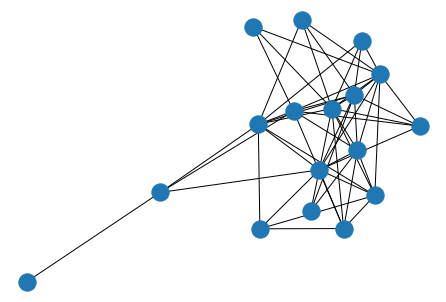

In [3]:
G_contact = nx.from_numpy_array(contact)
G_social = nx.from_numpy_array(social)

nx.draw_spring(G_contact)

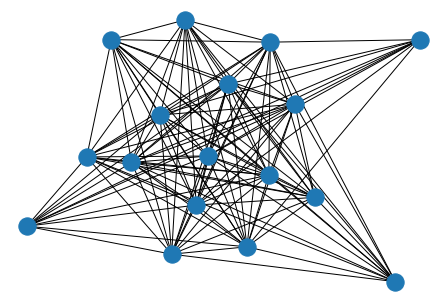

In [4]:
nx.draw_spring(G_social)

Using methods from Problem Set 5

In [5]:
def predictor_Baseline():
    # implements the baseline link predictor
    # input : none, because its output is independent of G
    # output: score(i,j) = r where r = Uniform(0,1)
    
    ####################################
    ##### do not modify above here #####

    return np.random.uniform(0.0,1.0)

In [6]:
def predictor_Jaccard(Gx,i,j):
    # implements the Jaccard coefficient link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = Jaccard(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    ####################################
    ##### do not modify above here #####
    
    epsilon = 1 / (Gx.number_of_nodes() - 2)
    
    i_neigh = [n for n in Gx.neighbors(i)]
    j_neigh = [n for n in Gx.neighbors(j)]
    
    neighbors = i_neigh + j_neigh
    neighbors_set = set(neighbors)
    
    if (len(neighbors) != 0):
        coeff = (len(neighbors) - len(neighbors_set)) / len(neighbors) 
    else:
        coeff = 0
    coeff += np.random.uniform(0.0, epsilon)
    
    return coeff

In [7]:
def predictor_DegreeProd(Gx,i,j):
    # implements the baseline link predictor
    # input : Gx:  a simple networkx graph
    #       : i,j: node indices i,j in Gx
    # output: score(i,j) = DegreeProduct(i,j) + Uniform(0,epsilon) for epsilon << 1 (a very small value)

    ####################################
    ##### do not modify above here #####

    epsilon = 1 / Gx.number_of_nodes()
    
    prod = Gx.degree[i] * Gx.degree[j]
    prod += np.random.uniform(0.0, epsilon)
    
    return prod

In [8]:
def get_candidate_edges(G):
    possible_edges = []
    nodes = G.nodes()
    for node1 in nodes:
        for node2 in nodes:
            if node1 != node2:
                possible_edges.append((node1, node2))
    
    real_edges = [e for e in G.edges()]
    candidate_edges = []
    
    for edge in possible_edges:
        if edge not in real_edges:
            candidate_edges.append(edge)
    
    return candidate_edges

In [9]:
def apply_Predictors(G,Y):
    # input : G, a networkx simple graph
    #         Y, list of missing links in G
    # output: S, table of the form [ i | j | tau | baseline | jaccard | degree product ]

    ####################################
    ##### do not modify above here #####

    edges = get_candidate_edges(G)
    
    S = []
    
    for edge in edges:
        data = []
        i = edge[0]
        j = edge[1]
        data.append(i)
        data.append(j)
        if edge in Y:
            data.append(True)
        else:
            data.append(False)
        data.append(predictor_Baseline())
        data.append(predictor_Jaccard(G, i, j))
        data.append(predictor_DegreeProd(G, i, j))
        S.append(data)
        
    return S

In [51]:
def tabulate_TPR_FPR(S):
    # see Lecture Notes 4
    # input : a data structure S containing a table whose rows have the form:
    #         [ i j tau score(i,j) ]
    #        sorted in descending order of score(i,j)
    # output: a data structure T containing a table whose rows have the form:
    #         [ i j tau TPR FPR score(i,j) ]
    #        sorted descending in score(i,j)

    ####################################
    ##### do not modify above here #####

    tpr = np.zeros(len(S))
    fpr = np.zeros(len(S))
    T = S.copy()
    T = np.insert(arr=T, values=tpr, obj=3, axis=1)
    T = np.insert(arr=T, values=fpr, obj=4, axis=1)
    
    tp = 0
    fp = 0
    
    tp_count = T.sum(axis=0)[2]
    fp_count = len(T) - tp_count
    
    for row in range(len(S)):
        if S[row][2] == 1:
            tp += 1
        else:
            fp += 1
        
        T[row][3] = tp/tp_count
        T[row][4] = fp/fp_count
        
    return T

In [52]:
def calculate_AUC(TPR,FPR):
    # see Lecture Notes 4
    # input : the TPR and FPR columns of your table (which have equal length and where TPR[0]=FPR[0]=0)
    # output: the AUC, a scalar on the unit interval

    ####################################
    ##### do not modify above here #####

    AUC = 0
    for i in range(1, len(TPR)):
        area = (FPR[i] - FPR[i-1]) * TPR[i]
        AUC += area
        
    return AUC

In [13]:
alpha = 0.9

Go_social = nx.Graph()

missing = []

for node in G_social.nodes():
    Go_social.add_node(node)

for edge in G_social.edges():
    if np.random.choice([True, False], p=[alpha,1-alpha]):
        Go_social.add_edges_from([edge])
    else:
        missing.append(edge)

In [49]:
prediction = apply_Predictors(Go_social, missing)

In [55]:
#print(prediction)
prediction = np.array(prediction)
prediction = prediction[np.argsort(prediction[:, 4])]
prediction = np.flipud(prediction)

print("{i},{j} : {tau} : {baseline}  {jaccard}  {degree prod}")
for row in prediction:
    print("{},{} : {} : {}  {}  {}".format(row[0], row[1], row[2], row[3], row[4], row[5]))


{i},{j} : {tau} : {baseline}  {jaccard}  {degree prod}
8.0,0.0 : 0.0 : 0.5897762210379275  0.5363589940664261  182.05194939465673
9.0,10.0 : 1.0 : 0.6933008001787225  0.510271476206331  168.04432341409012
11.0,7.0 : 0.0 : 0.779734054722189  0.5075273507204029  210.05018107030187
7.0,11.0 : 1.0 : 0.7736798901118194  0.4992701507644433  210.0344042684479
12.0,4.0 : 0.0 : 0.9994603178062058  0.4991590469528359  180.01293034761719
6.0,3.0 : 0.0 : 0.761098298834313  0.48763142988455743  156.0474951872835
7.0,4.0 : 0.0 : 0.9826860017326184  0.48702820812667547  225.00624764782185
0.0,8.0 : 1.0 : 0.37893378026634217  0.48446645348047074  182.01373780646952
10.0,9.0 : 0.0 : 0.06599722327144797  0.48362733132591046  168.0188831653606
14.0,12.0 : 0.0 : 0.1438307813002302  0.4812024522595204  144.04502341843306
11.0,4.0 : 0.0 : 0.4482282339998228  0.4798395668309625  210.01430270915642
6.0,2.0 : 0.0 : 0.45518317399093156  0.4797223423112909  156.05148205546033
9.0,7.0 : 0.0 : 0.8690119760582691  

In [61]:
base = np.array(prediction[:,0:3])
print(base)

np.set_printoptions(suppress=True)

baseline = np.array(prediction[:,0:4])
print(baseline)
baseline = baseline[np.argsort(baseline[:, 3])]
baseline = np.flipud(baseline)

jaccard = prediction[:,4]
# print(jaccard) 
jaccard = np.insert(arr=base, values=jaccard, axis=1, obj=3)
print(jaccard)

deg = prediction[:,5]
deg = np.insert(arr=base, values=deg, axis=1, obj=3)
deg = deg[np.argsort(deg[:, 3])]
deg = np.flipud(deg)
print(deg)

baseline_table = tabulate_TPR_FPR(baseline)
jaccard_table = tabulate_TPR_FPR(jaccard)
deg_table = tabulate_TPR_FPR(deg)
    
auc_baseline = calculate_AUC(baseline_table[:,3], baseline_table[:,4])
auc_jaccard = calculate_AUC(jaccard_table[:,3], jaccard_table[:,4])
auc_deg = calculate_AUC(deg_table[:,3], deg_table[:,4])
print("AUC for Baseline: ", auc_baseline)
print("AUC for Jaccard: ", auc_jaccard)
print("AUC for Degree Product: ", auc_deg)

[[ 8.  0.  0.]
 [ 9. 10.  1.]
 [11.  7.  0.]
 [ 7. 11.  1.]
 [12.  4.  0.]
 [ 6.  3.  0.]
 [ 7.  4.  0.]
 [ 0.  8.  1.]
 [10.  9.  0.]
 [14. 12.  0.]
 [11.  4.  0.]
 [ 6.  2.  0.]
 [ 9.  7.  0.]
 [ 1. 15.  1.]
 [ 3.  6.  1.]
 [ 9.  4.  0.]
 [ 6.  1.  0.]
 [11.  1.  0.]
 [ 2.  6.  1.]
 [ 4. 12.  0.]
 [ 3.  8.  1.]
 [ 7.  1.  0.]
 [ 6. 15.  1.]
 [ 4.  1.  0.]
 [ 8.  1.  0.]
 [ 9.  5.  0.]
 [15.  9.  0.]
 [16.  0.  0.]
 [ 8.  2.  0.]
 [13.  7.  0.]
 [15.  1.  0.]
 [ 5.  9.  0.]
 [13.  4.  0.]
 [ 0. 16.  0.]
 [11.  9.  0.]
 [ 2. 13.  1.]
 [ 2.  3.  1.]
 [ 9.  1.  0.]
 [13. 14.  1.]
 [ 4.  0.  0.]
 [ 7.  0.  0.]
 [12. 13.  0.]
 [10.  0.  0.]
 [13. 12.  0.]
 [15.  2.  0.]
 [14. 10.  0.]
 [10.  2.  0.]
 [ 7.  6.  0.]
 [13. 11.  0.]
 [ 7.  3.  0.]
 [15.  6.  0.]
 [14. 11.  0.]
 [15.  4.  0.]
 [ 3.  2.  0.]
 [ 5.  1.  0.]
 [10.  3.  0.]
 [11. 14.  1.]
 [14.  0.  0.]
 [ 6.  4.  0.]
 [ 5. 10.  0.]
 [ 4.  2.  0.]
 [ 8.  4.  0.]
 [14.  9.  0.]
 [12.  1.  0.]
 [ 5.  4.  0.]
 [11.  8.  0.]
 [ 3. 10. 

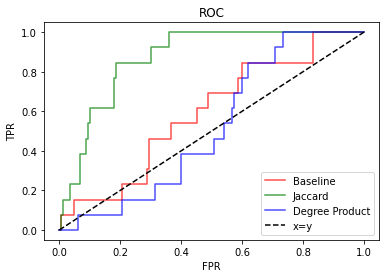

In [62]:
baseline_tpr = baseline_table[:,3]
baseline_tpr = np.insert(arr=baseline_tpr, obj=0, values=0)
baseline_fpr = baseline_table[:,4]
baseline_fpr = np.insert(arr=baseline_fpr, obj=0, values=0)

jaccard_tpr = jaccard_table[:,3]
jaccard_tpr = np.insert(arr=jaccard_tpr, obj=0, values=0)
jaccard_fpr = jaccard_table[:,4]
jaccard_fpr = np.insert(arr=jaccard_fpr, obj=0, values=0)

deg_tpr = deg_table[:,3]
deg_tpr = np.insert(arr=deg_tpr, obj=0, values=0)
deg_fpr = deg_table[:,4]
deg_fpr = np.insert(arr=deg_fpr, obj=0, values=0)

x = np.linspace(0,1,len(deg_tpr))

plt.plot(baseline_fpr, baseline_tpr, color='r', alpha=0.7, label="Baseline")
plt.plot(jaccard_fpr, jaccard_tpr, color='g', alpha=0.7, label="Jaccard")
plt.plot(deg_fpr, deg_tpr, color='b', alpha=0.7, label="Degree Product")
plt.plot(x, x, color='black', linestyle='dashed', label="x=y")

plt.title('ROC')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc='lower right')

Jaccard seems to do a much better job than degree product at predicting missing edges for this social network from the single comparison. Now to repeat it.

In [63]:
def missing_edge_comparison(alpha, nreps):
    AUCs_base = [] 
    AUCs_jacc = []
    AUCs_degp = []
    
    for i in range(nreps):
        Go = nx.Graph()

        missing = []

        for node in G_social.nodes():
            Go.add_node(node)

        for edge in G_social.edges():
            if np.random.choice([True, False], p=[alpha,1-alpha]):
                Go.add_edges_from([edge])
            else:
                missing.append(edge)

        prediction = apply_Predictors(Go, missing)
        prediction = np.array(prediction)
        prediction = prediction[np.argsort(prediction[:, 4])]
        prediction = np.flipud(prediction)

        base = np.array(prediction[:,0:3])

        baseline = np.array(prediction[:,0:4])
        baseline = baseline[np.argsort(baseline[:, 3])]
        baseline = np.flipud(baseline)

        jaccard = prediction[:,4]
        jaccard = np.insert(arr=base, values=jaccard, axis=1, obj=3)
        jaccard = jaccard[np.argsort(jaccard[:, 3])]
        jaccard = np.flipud(jaccard)

        deg = prediction[:,5]
        deg = np.insert(arr=base, values=deg, axis=1, obj=3)
        deg = deg[np.argsort(deg[:, 3])]
        deg = np.flipud(deg)

        baseline_table = tabulate_TPR_FPR(baseline)
        jaccard_table = tabulate_TPR_FPR(jaccard)
        deg_table = tabulate_TPR_FPR(deg)

        auc_baseline = calculate_AUC(baseline_table[:,3], baseline_table[:,4])
        auc_jaccard = calculate_AUC(jaccard_table[:,3], jaccard_table[:,4])
        auc_deg = calculate_AUC(deg_table[:,3], deg_table[:,4])

        AUCs_base.append(auc_baseline)
        AUCs_jacc.append(auc_jaccard)
        AUCs_degp.append(auc_deg)
        
    auc_base_mean = sum(AUCs_base) / len(AUCs_base)
    auc_jacc_mean = sum(AUCs_jacc) / len(AUCs_jacc)
    auc_degp_mean = sum(AUCs_degp) / len(AUCs_degp)
    
    return auc_base_mean, auc_jacc_mean, auc_degp_mean

In [66]:
alphas = [0.1,0.3,0.5,0.7,0.9]
baselines = []
jaccards = []
degreeps = []

reps = 100
for alpha in alphas:
    print("Alpha: {}".format(alpha))
    aucs = missing_edge_comparison(alpha, reps)
    baselines.append(aucs[0])
    jaccards.append(aucs[1])
    degreeps.append(aucs[2])

Alpha: 0.1
Alpha: 0.3
Alpha: 0.5
Alpha: 0.7
Alpha: 0.9


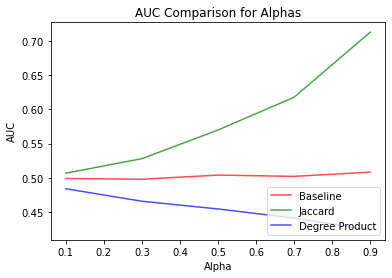

In [67]:
plt.plot(alphas, baselines, color='r', alpha=0.7, label="Baseline")
plt.plot(alphas, jaccards, color='g', alpha=0.7, label="Jaccard")
plt.plot(alphas, degreeps, color='b', alpha=0.7, label="Degree Product")

plt.title('AUC Comparison for Alphas')
plt.ylabel('AUC')
plt.xlabel('Alpha')
plt.legend(loc='lower right')

In [ ]:
Jaccard is definitely the best model for this. Degree product seems to be somewhat inversely correlated, but it doesn't perform as 